## Load Imports

In [1]:
# python imports
from math import pi
import json
import os

# third-party imports
import pandas as pd
import numpy as np

from sklearn import preprocessing

import matplotlib.pyplot as plt

## Load results

In [2]:
NETWORK_NAME = 'Network01'

In [3]:
cvss_stats = pd.DataFrame()
frape_stats = pd.DataFrame()
feature_importances = None
vulns = pd.DataFrame()

occurrences = 0

for file in os.listdir(f'../output/{NETWORK_NAME}/'):
    if file.endswith('.json'):
        with open(f'../output/{NETWORK_NAME}/{file}') as f:
            
            occurrences += 1
            
            json_file = json.load(f)
            
            # loading cvss and frape values
            
            iterations = json_file['iterations']
        
            cvss = pd.DataFrame.from_records(iterations['cvss_stats'])
            frape = pd.DataFrame.from_records(iterations['frape_stats'])
                       
            if not cvss_stats.empty:
                cvss_stats += cvss
                frape_stats += frape
            else:
                cvss_stats = cvss
                frape_stats = frape
            
            # loading feature importances
            
            features = pd.Series(json_file['feature_importances'])
                           
            if not feature_importances:
                feature_importances = {name: [] for name in features.index}
            
            for name, value in zip(features.index, features.values):
                feature_importances[name].append(value)
            
            # loading vulnerabilities to analysis
            
            vulns = pd.DataFrame.from_records(json_file['vulnerabilities'])

In [4]:
cvss_stats /= occurrences
frape_stats /= occurrences

feature_importances = pd.DataFrame(feature_importances, columns=feature_importances.keys())

feature_importances_std = feature_importances.std()
feature_importances = feature_importances.mean()

## Utils

In [5]:
def normalize_min_max_values(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(df.values)
    return pd.DataFrame(x_scaled, columns=df.columns)

In [6]:
def normalize_values(df):
    return df.apply(lambda x: x / x.max())

In [7]:
# https://en.wikipedia.org/wiki/Shoelace_formula
def poligon_area(theta, r):
    # turn radial grid points into (x, y)
    x = r[:-1] * np.sin(theta[:-1])  
    y = r[:-1] * np.cos(theta[:-1])
    
    return 0.5 * np.abs(np.dot(x[:-1], np.roll(y[:-1], 1)) - np.dot(y[:-1], np.roll(x[:-1], 1)))

In [8]:
# https://www.pythoncharts.com/matplotlib/radar-charts/
def print_graph_polar(cvss_stats, frape_stats, key, save_fig=False):       
    cvss = cvss_stats.iloc[[key]]
    cvss = np.squeeze(cvss.values).tolist()
    
    frape = frape_stats.iloc[[key]]
    frape = np.squeeze(frape.values).tolist()
            
    labels = cvss_stats.columns.tolist()
    labels = [label.replace('_', ' ').capitalize() for label in labels]
        
    angles = np.linspace(start=0, stop=2 * np.pi, num=len(labels), endpoint=False).tolist()
    
    cvss += cvss[:1]
    frape += frape[:1]
    labels += labels[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
            
    cvss_area = poligon_area(angles, cvss)
    frape_area = poligon_area(angles, frape)
    
    ax.plot(angles, cvss, color='#3E6D9C', linewidth=1, label=f'CVSS (poly area = {cvss_area:.2f})')
    ax.fill(angles, cvss, color='#3E6D9C', alpha=0.25)
    
    ax.plot(angles, frape, color='#FD841F', linewidth=1, label=f'FRAPE (poly area = {frape_area:.2f})')
    ax.fill(angles, frape, color='#FD841F', alpha=0.25)
    
    # Fix axis to go in the right order and start at 12 o'clock.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines for each angle and label.
    ax.set_thetagrids(np.degrees(angles), labels)

    # Go through labels and adjust alignment based on where
    # it is in the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    # Ensure radar goes from 0 to 100.
    ax.set_ylim(0, 1)
    # You can also set gridlines manually like this:
    # ax.set_rgrids([20, 40, 60, 80, 100])

    # Set position of y-labels (0-100) to be in the middle
    # of the first two axes.
    ax.set_rlabel_position(180 / len(labels))

    # Add some custom styling.
    # Change the color of the tick labels.
    ax.tick_params(colors='#222222')
    # Make the y-axis (0-100) labels smaller.
    ax.tick_params(axis='y', labelsize=8)
    # Change the color of the circular gridlines.
    ax.grid(color='#AAAAAA')
    # Change the color of the outermost gridline (the spine).
    ax.spines['polar'].set_color('#222222')
    # Change the background color inside the circle itself.
    ax.set_facecolor('#FAFAFA')
    
    # Add title.
    ax.set_title(f'Vulnerability Remediation Strategies (iteration={key})', y=1.08)

    # Add a legend as well.
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    if save_fig:
        plt.savefig(f'spiderchart-{key}.png', bbox_inches='tight')

## Running

In [9]:
cvss_stats = normalize_values(cvss_stats)
frape_stats = normalize_values(frape_stats)

# cvss_stats = normalize_min_max_values(cvss_stats)
# frape_stats = normalize_min_max_values(frape_stats)

In [10]:
feature_importances = feature_importances[cvss_stats.columns]

feature_importances.drop(
    labels=['cve_published_date', 'exploit_published_date', 'epss', 'attack_type_none', 'vendor_other'], inplace=True)

# feature_importances += 3 * feature_importances_std

feature_importances = feature_importances.sort_values(ascending=False).head(12)
feature_importance_names = feature_importances.index.tolist()

std_values = feature_importances_std[feature_importance_names].values

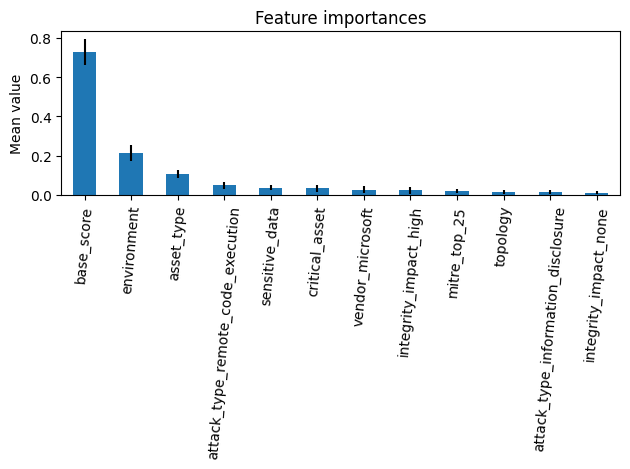

In [11]:
fig, ax = plt.subplots()

feature_importances.plot.bar(yerr=std_values, ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Mean value")

ax.set_xticklabels(feature_importance_names, rotation=85)

fig.tight_layout()

In [12]:
cvss_stats = cvss_stats[feature_importance_names]
frape_stats = frape_stats[feature_importance_names]

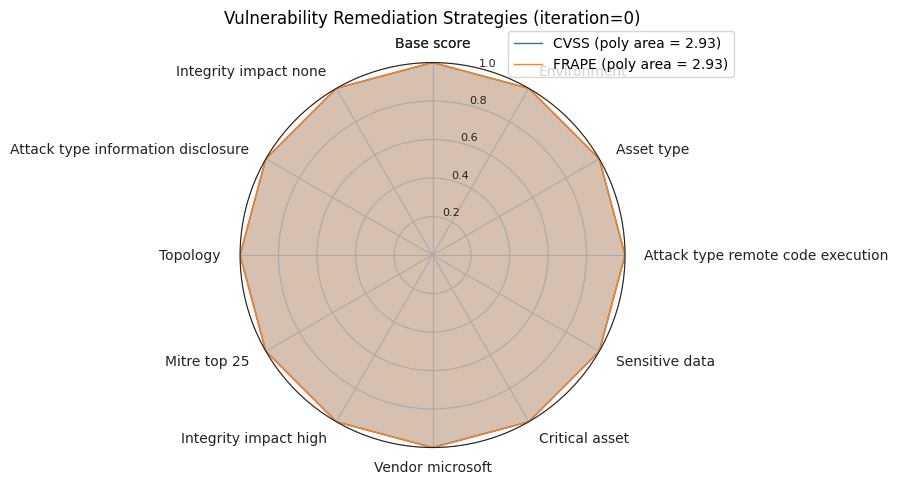

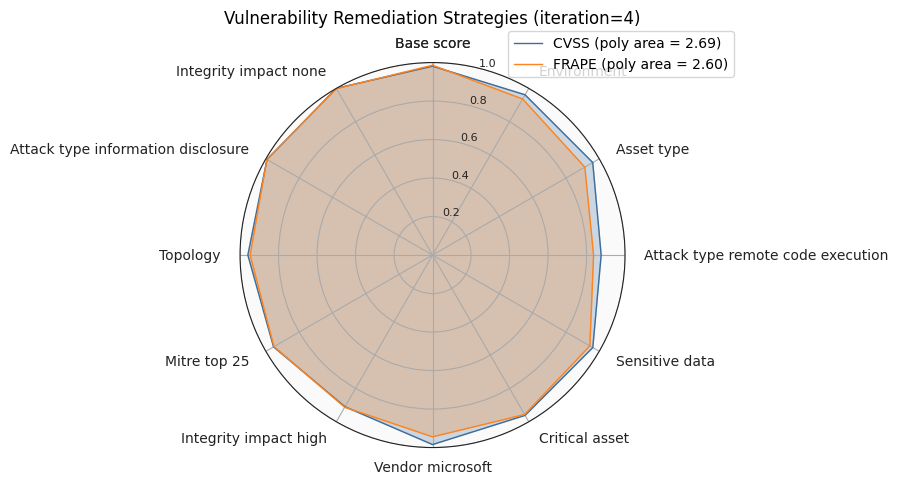

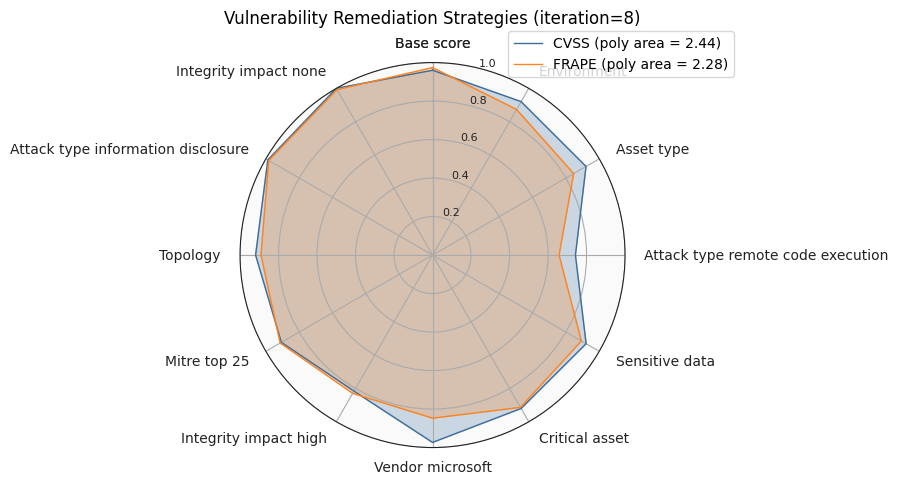

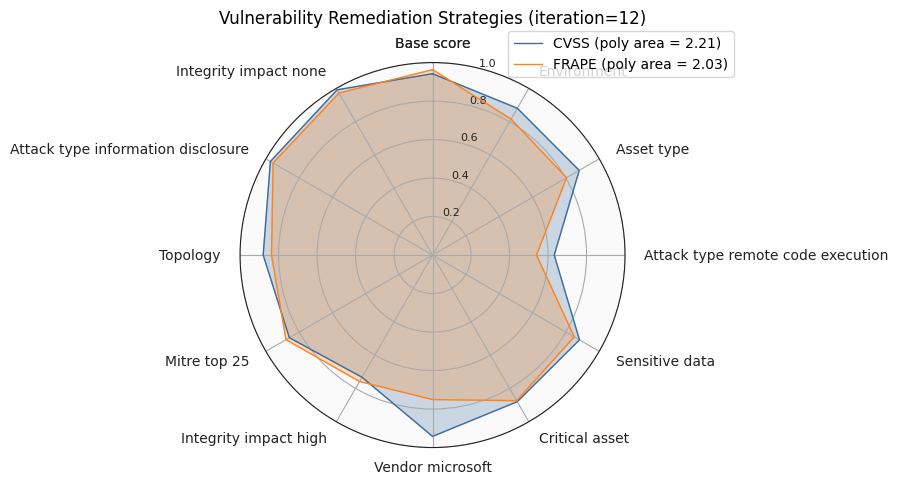

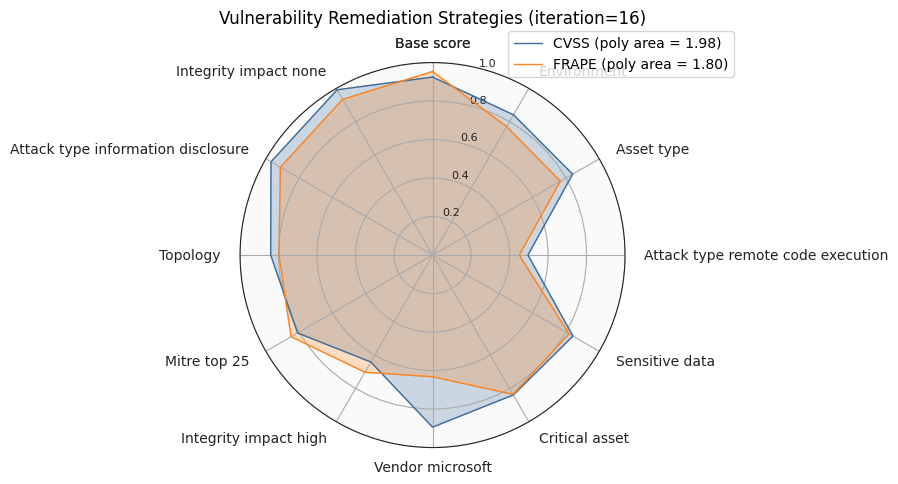

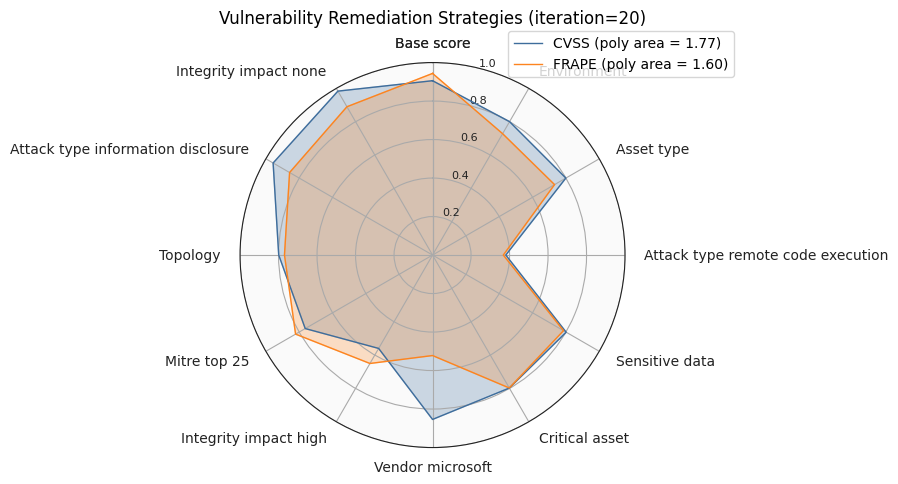

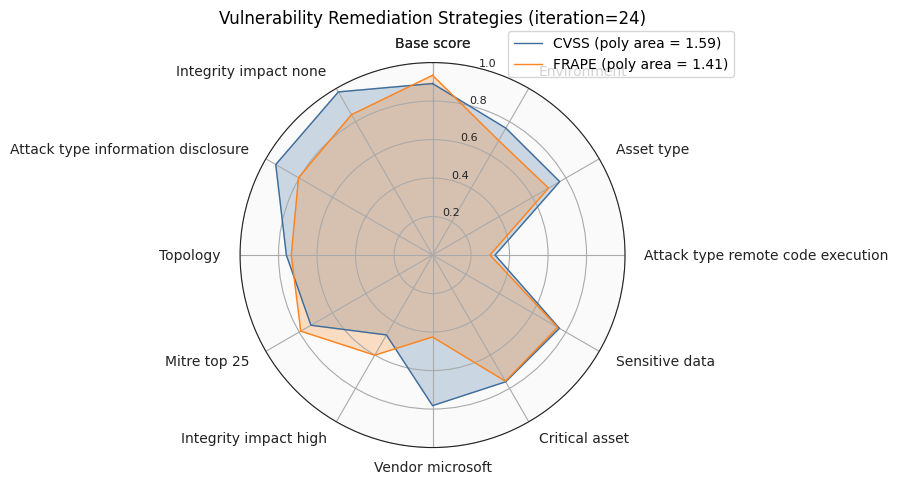

In [13]:
for key in range(0, 26, 4):
    print_graph_polar(cvss_stats, frape_stats, str(key), save_fig=False)